In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from keplergl import KeplerGl
import json

plt.rc('font', family='NanumGothic')


In [2]:
data_path = "/media/data/geodata/seoul-pop/생활이동_행정동_202106.csv"

In [3]:
df = pd.read_csv(
    data_path, 
    encoding='euc_kr', 
    na_values=['*'], 
    names=['yyyymm','yoil','et','oricd','descd', 'gender', 'age', 'movetype', 'triptime', 'popu'],
    header=1)
df.head()

,yyyymm,yoil,et,oricd,descd,gender,age,movetype,triptime,popu
0,202106,일,0,1101053,1101053,F,15,HH,10,4.04
1,202106,일,0,1101053,1101053,F,15,WH,20,4.04
2,202106,일,0,1101053,1101053,F,20,WE,10,NaN
3,202106,일,0,1101053,1101053,F,20,HH,20,8.23
4,202106,일,0,1101053,1101053,F,20,WW,10,4.42


In [4]:
df = df.assign(
    popu=lambda x: x.popu.fillna(2),
    oricd=lambda x: np.where(x.oricd<100000, x.oricd*100, x.oricd),
    descd=lambda x: np.where(x.descd<100000, x.descd*100, x.descd),
)
df.to_parquet("../data/seoul_dong_202106.parquet")

In [5]:
!ls -lh ../data

total 479M
-rwxrwxrwx 1 root root 479M Sep  9 20:29 seoul_dong_202106.parquet


In [2]:
df = pd.read_parquet("../data/seoul_dong_202106.parquet", columns=['yoil', 'popu'])

## 요일별 이동량

In [3]:
import calendar
from calendar import weekday, monthrange, SUNDAY
import datetime
import collections

# 요일별 날짜 수 세기
year = 2021
month = 6
s, e = monthrange(year, month)
days = [weekday(year, month, d) for d in range(s, e+1)]
day_count = dict(collections.Counter(days))
day_count = [day_count[i] for i in sorted(day_count.keys())]
day_order = ["월", "화", "수", "목", "금", "토", "일"]


<AxesSubplot:xlabel='yoil'>

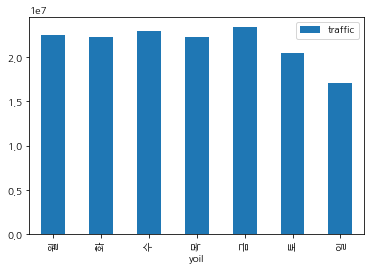

In [4]:
tr_yoil = df.groupby('yoil').agg('sum')['popu']
df_yoil = pd.DataFrame({
    'day':day_order, 
    'day_count': day_count,
    'traffic_sum': tr_yoil.loc[day_order]
}).assign(traffic=lambda x: x.traffic_sum/x.day_count)
df_yoil.loc[day_order].plot.bar(y='traffic')


## 지리적 패턴

In [5]:
dfg = pd.read_parquet(
    "../data/seoul_dong_202106.parquet", 
    columns=['yoil', 'oricd', 'descd', 'movetype', 'popu']
).assign(
    weekday=lambda x: np.where(x.yoil.isin(day_order[:5]), 1, 0),
).groupby(['weekday', 'oricd', 'descd', 'movetype']).agg(popu=('popu', 'sum')).reset_index()
dfg

,weekday,oricd,descd,movetype,popu
0,0,1101053,1101053,EE,17049.47
1,0,1101053,1101053,EH,5739.88
2,0,1101053,1101053,EW,984.97
3,0,1101053,1101053,HE,5055.07
4,0,1101053,1101053,HH,3246.75
...,...,...,...,...,...
6576979,1,3900000,1125074,EE,201.04
6576980,1,3900000,1125074,EH,686.46
6576981,1,3900000,1125074,EW,40.71
6576982,1,3900000,1125074,HE,77.53


In [6]:
dfg_r = dfg.assign(
    flow=lambda x: np.where(x.weekday==1, x.popu/sum(day_count[:5]), x.popu/sum(day_count[5:]))
).query('oricd != descd'
).query('flow>=10')
dfg_r

,weekday,oricd,descd,movetype,popu,flow
9,0,1101053,1101054,EE,3235.60,404.450000
10,0,1101053,1101054,EH,290.55,36.318750
11,0,1101053,1101054,EW,82.07,10.258750
12,0,1101053,1101054,HE,330.82,41.352500
14,0,1101053,1101054,WE,316.11,39.513750
...,...,...,...,...,...,...
6576957,1,3900000,1125067,EH,347.12,15.778182
6576966,1,3900000,1125071,EH,284.56,12.934545
6576970,1,3900000,1125072,EH,344.43,15.655909
6576974,1,3900000,1125073,EH,365.84,16.629091


## 행정동 중심 좌표 얻기


In [7]:
centroid_file_url = "https://raw.githubusercontent.com/vuski/admdongkor/master/ver20180301/InnerCentroid.tsv"
df_centroid = pd.read_csv(centroid_file_url, sep='\t')
gdf_centroid = gpd.GeoDataFrame(
    df_centroid, 
    geometry=gpd.points_from_xy(df_centroid.x, df_centroid.y), 
    crs="EPSG:5179"
).to_crs("EPSG:4326"
).assign(
    x=lambda x:x.geometry.x,
    y=lambda x:x.geometry.y
)
gdf_centroid

,admcd,admnm,sido,sgg,emd,sidosgg,sggemd,x,y,geometry
0,1101053,서울특별시 종로구 사직동,서울특별시,종로구,사직동,서울특별시 종로구,종로구 사직동,126.970884,37.573390,POINT (126.97088 37.57339)
1,1101054,서울특별시 종로구 삼청동,서울특별시,종로구,삼청동,서울특별시 종로구,종로구 삼청동,126.982324,37.586023,POINT (126.98232 37.58602)
2,1101055,서울특별시 종로구 부암동,서울특별시,종로구,부암동,서울특별시 종로구,종로구 부암동,126.965687,37.595359,POINT (126.96569 37.59536)
3,1101056,서울특별시 종로구 평창동,서울특별시,종로구,평창동,서울특별시 종로구,종로구 평창동,126.968828,37.614040,POINT (126.96883 37.61404)
4,1101057,서울특별시 종로구 무악동,서울특별시,종로구,무악동,서울특별시 종로구,종로구 무악동,126.958849,37.577581,POINT (126.95885 37.57758)
...,...,...,...,...,...,...,...,...,...,...
1224,3127000,경기도 포천시,경기도,포천시,_,경기도 포천시,_,127.237579,37.967666,POINT (127.23758 37.96767)
1225,3128000,경기도 여주시,경기도,여주시,_,경기도 여주시,_,127.644281,37.287624,POINT (127.64428 37.28762)
1226,3135000,경기도 연천군,경기도,연천군,_,경기도 연천군,_,127.021478,38.105097,POINT (127.02148 38.10510)
1227,3137000,경기도 가평군,경기도,가평군,_,경기도 가평군,_,127.407659,37.811249,POINT (127.40766 37.81125)


## 좌표를 join하기

In [8]:
dfg_od = dfg_r.merge(
    gdf_centroid[['admcd', 'x', 'y']].rename(columns={'x':'ox', 'y':'oy'}), 
    how='inner', 
    left_on='oricd', right_on='admcd'
).merge(
    gdf_centroid[['admcd', 'x', 'y']].rename(columns={'x':'dx', 'y':'dy'}), 
    how='inner', 
    left_on='descd', right_on='admcd'
).drop(columns=['admcd_x', 'admcd_y', 'popu'])
dfg_od

,weekday,oricd,descd,movetype,flow,ox,oy,dx,dy
0,0,1101053,1101054,EE,404.450000,126.970884,37.573390,126.982324,37.586023
1,0,1101053,1101054,EH,36.318750,126.970884,37.573390,126.982324,37.586023
2,0,1101053,1101054,EW,10.258750,126.970884,37.573390,126.982324,37.586023
3,0,1101053,1101054,HE,41.352500,126.970884,37.573390,126.982324,37.586023
4,0,1101053,1101054,WE,39.513750,126.970884,37.573390,126.982324,37.586023
...,...,...,...,...,...,...,...,...,...
594635,0,1123077,3128035,HE,21.413750,127.035515,37.529180,127.440524,37.401471
594636,0,1124052,3107055,EH,14.775000,127.109972,37.529657,127.059075,37.077512
594637,1,1124052,3121053,EE,10.594545,127.109972,37.529657,127.420611,37.288299
594638,1,1124069,3122032,EH,11.046364,127.120110,37.478952,127.338536,36.980912


In [20]:
dfg_od.to_csv("../data/odflow_202106.csv")

## Kepler.GL에서 보기

In [18]:
map_config = json.load(open('config.json'))
  
map = KeplerGl(
    height=800, 
    data={"data": dfg_od},
    config=map_config)



User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [19]:
map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['data'], 'id': '87f1emeqs', …